# HRNet and OpenPose Comparison

In this notebook we use both our implementations of HRNet and OpenPose to estimate the human poses in an image from the COCO validation set.
Furthermore, we evaluate the results both qualitatively and quantitatively for the sampled image. 

In [1]:
import os
import sys

import numpy as np
import cv2
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

sys.path.append("..")

import models
import data
from data.custom_transforms import Resize, Normalize
import data.data_processing as data_processing
import lib.utils as utils
import lib.visualizations as visualizations
import lib.pose_parsing as pose_parsing
import lib.metrics as metrics
from lib.inference import multiscale_inference_open_pose
from lib.loss import PersonMSELoss
from CONFIG import CONFIG
import CONSTANTS

In [2]:
exp_name = os.path.join("notebook_tests", "hrnet_notebook")
hrnet_exp = os.path.join(CONFIG["paths"]["experiments_path"], exp_name)
exp_name = "test/experiment_2020-06-04_08-06-38"
openpose_exp = os.path.join(CONFIG["paths"]["experiments_path"], exp_name)

data_path = CONFIG["paths"]["data_path"]
images_path = os.path.join(data_path, "images", "validation")
original_imgs_path = os.path.join(data_path, "original_images", "val2017")
labels_path = os.path.join(data_path, "annotations")
labels_file = os.path.join(labels_path, "person_keypoints_validation.json")

preds_hrnet_file = os.path.join(hrnet_exp, CONFIG["paths"]["submission"])
preds_openpose_file = os.path.join(openpose_exp, CONFIG["paths"]["submission"])

In [3]:
pose_parsing.SKELETON = CONSTANTS.SKELETON_HRNET
data_processing.TO_COCO_MAP = CONSTANTS.COCO_MAP_HRNET
data_processing.SKIP_NECK = False

In [4]:
%reload_ext autoreload
%autoreload 2

# Loading the Data

In [5]:
openpose_dataset = data.OpenPoseCoco(root=original_imgs_path, annFile=labels_file,
                                     original_imgs_path=original_imgs_path,
                                     model_name="OpenPose",
                                     transforms=transforms.Compose([
                                         Resize(size=600)
                                     ]))

loading annotations into memory...
Done (t=0.50s)
creating index...
index created!


In [10]:
normalize = Normalize(
    mean=[128, 128, 128], std=[256, 256, 256]
)
hrnet_dataset = data.HRNetCoco(root=data_path, img_path=original_imgs_path,
                               labels_path=labels_file, is_train=False,
                               transform=transforms.Compose([
                                   normalize,
                                   transforms.ToTensor(),
                               ]))

loading annotations into memory...
Done (t=0.61s)
creating index...
index created!


In [11]:
image_idx = np.random.randint(low=0, high=len(openpose_dataset))
image_name = openpose_dataset.get_name_given_id(image_idx)
print(f"ID: {image_idx}  --  Image: {image_name}")

ID: 113  --  Image: 000000491867.jpg


In [12]:
openpose_img, openpose_heatmaps, openpose_pafs, openpose_mask, openpose_metadata = openpose_dataset[image_idx]

In [13]:
hrnet_inputs, hrnet_targets, hrnet_weights, hrnet_metadata = hrnet_dataset.get_all_samples_given_name(image_name)
n_humans = hrnet_inputs.shape[0]
full_img_path = hrnet_metadata["image"][0]
full_img = cv2.imread(full_img_path, cv2.IMREAD_COLOR)
full_img = cv2.cvtColor(full_img, cv2.COLOR_RGB2BGR)

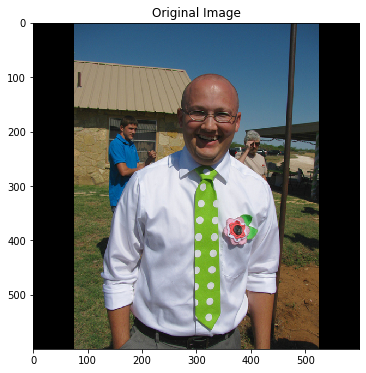

In [14]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(6,6)
visualizations.visualize_image(openpose_img, ax=ax, title="Original Image", bgr=True)

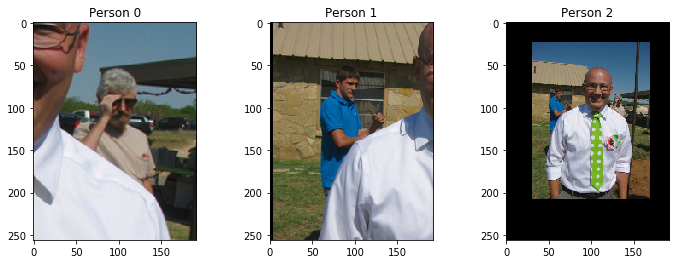

In [15]:
fig, ax = plt.subplots(1,n_humans)
fig.set_size_inches(4*n_humans,4)
for i in range(n_humans):
    if(n_humans==1):
        visualizations.visualize_image(np.array(hrnet_inputs[i,:]), ax=ax, title=f"Person {i}", bgr=False)
    else:
        visualizations.visualize_image(np.array(hrnet_inputs[i,:]), ax=ax[i], title=f"Person {i}", bgr=False)

# Models

In [16]:
# HRNet Model
hrnet = models.PoseHighResolutionNet(is_train=False)
pretrained_path = os.path.join(CONFIG["paths"]["pretrained_path"], "HRnet", "pose_hrnet_w32_256x192.pth")
hrnet.load_state_dict(torch.load(pretrained_path))

<All keys matched successfully>

In [17]:
open_pose = models.OpenPose()
pretrained_path = os.path.join(CONFIG["paths"]["pretrained_path"], "OpenPose", "checkpoint_iter_370000.pth")
open_pose.load_pretrained(pretrained_path)

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = "cpu"  # for just one image we can simply use 'cpu'
hrnet = hrnet.to(device)
hrnet = hrnet.eval()

open_pose = open_pose.to(device)
open_pose = open_pose.eval()

# Inference


In [19]:
hrnet_output = hrnet(hrnet_inputs.float())
scaled_hrnet_output = F.interpolate(hrnet_output.clone().detach(), (256, 192),
                                    mode="bilinear", align_corners=True)
n_images = hrnet_output.shape[0]
n_joints = hrnet_output.shape[1]

In [20]:
scales = [0.5, 1.0, 1.5, 2.0]
feed_open_pose_img = torch.Tensor(openpose_img.reshape(1, *openpose_img.shape))
openpose_hms, openpose_pafs = multiscale_inference_open_pose(model=open_pose, imgs=feed_open_pose_img, scales=scales,
                                                             image_size=600, device=device, model_name="OpenPose")

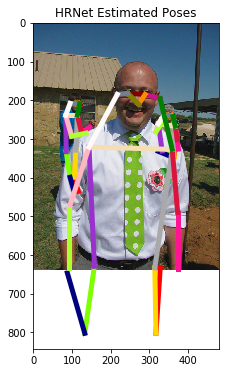

In [21]:
# pose parsing for HRNet
pose_parsing.SKELETON = CONSTANTS.SKELETON_HRNET
data_processing.TO_COCO_MAP = CONSTANTS.COCO_MAP_HRNET
data_processing.SKIP_NECK = False

centers = hrnet_metadata["center"].numpy()
scales = hrnet_metadata["scale"].numpy()
score = hrnet_metadata["score"].numpy()

hrnet_keypoints, hrnet_max_vals, coords = pose_parsing.get_final_preds_hrnet(scaled_hrnet_output.cpu().numpy(), centers, scales)
hrnet_pose_entries, hrnet_all_keypoints = pose_parsing.create_pose_entries(hrnet_keypoints)

hrnet_all_keypoints = [hrnet_all_keypoints[:, 1], hrnet_all_keypoints[:, 0], hrnet_all_keypoints[:, 2], hrnet_all_keypoints[:, 3]]
hrnet_all_keypoints = np.array(hrnet_all_keypoints).T

fig, ax = plt.subplots(1,1)
fig.set_size_inches(8,6)

title = "HRNet Estimated Poses"
visualizations.draw_pose(full_img, hrnet_pose_entries, hrnet_all_keypoints, ax=ax, title=title)

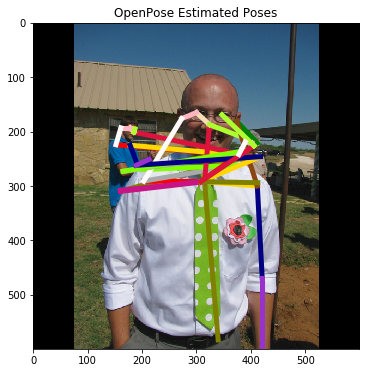

In [22]:
# pose parsing for OpenPose
pose_parsing.BODY_PARTS_PAF_IDS = CONSTANTS.BODY_PARTS_PAF_IDS_OPEN_POSE
pose_parsing.SKELETON = CONSTANTS.SKELETON_OPEN_POSE
data_processing.SKIP_NECK = True

coords, openpose_keypoints = pose_parsing.extract_joins_heatmap(openpose_hms[0,:], min_distance=1, thr=0.3)

openpose_pose_entries, openpose_all_keypoints, pose_entries_aux = pose_parsing.group_keypoints(openpose_keypoints, openpose_pafs[0,:],
                                                                             min_paf_score=0.05, thr_ratio=0.99, debug=True)

fig, ax = plt.subplots(1,1)
fig.set_size_inches(8, 6)

title = "OpenPose Estimated Poses"
visualizations.draw_pose(openpose_img, openpose_pose_entries, openpose_all_keypoints, ax=ax, title=title, preprocess=True, bgr=True)

# HRNet Evaluation

In [25]:
all_preds = np.zeros((n_humans, 17, 3), dtype=np.float32)
all_bboxes = np.zeros((n_humans, 6))
print(n_humans)
all_preds[:,:,:2] = hrnet_keypoints[:,:,:2]
all_preds[:,:,2:3] = hrnet_max_vals
all_bboxes[:, 0:2] = centers[:, 0:2]
all_bboxes[:, 2:4] = scales[:, 0:2]
all_bboxes[:, 4] = np.prod(scales*200, 1)
all_bboxes[:, 5] = score
img_path = hrnet_metadata["image"]

3


In [26]:
utils.reset_predictions_file(hrnet_exp)
metrics.generate_submission_hrnet(all_preds=[all_preds], all_bboxes=[all_bboxes], 
                                  image_names=img_path, preds_file=preds_hrnet_file)

In [27]:
hrnet_stats = metrics.compute_precision(labels_file=labels_file, preds_file=preds_hrnet_file)

loading annotations into memory...
Done (t=0.80s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.00s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] = 0.855
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] = 1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] = 1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] = 0.850
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] = 0.900
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] = 0.867
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] = 1.000
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] = 1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | ma

# OpenPose Evaluation

In [28]:
# computing predictions, loading previous results and appending new ones
utils.reset_predictions_file(openpose_exp)
cur_predictions = metrics.compute_predictions_openpose(openpose_hms[:,:], openpose_pafs[:,:], openpose_metadata, cur_size=600)
utils.update_predictions_file(cur_predictions, openpose_exp)

In [29]:
openpose_stats = metrics.compute_precision(labels_file=labels_file, preds_file=preds_openpose_file)

loading annotations into memory...
Done (t=0.63s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.00s).
Accumulating evaluation results...
DONE (t=0.00s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] = 0.000
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | ma

In [ ]:
plt.figure(figsize=(40,60))
for i in range(18):
    plt.subplot(6,5,i+1)
    ax = plt.gca()
    title = f"Keypoint Pred: {CONSTANTS.IDX_TO_KPT_NAME_OPEN_POSE[i]}"
    visualizations.overlay_heatmap(heatmap=openpose_hms[0,i,:].numpy(), img=openpose_img, ax=ax, bgr=True)
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(40,60))
for i in range(19):
    plt.subplot(6,5,i+1)
    ax = plt.gca()
    visualizations.overlay_paf(pafs=openpose_pafs[0,2*i:2*i+2,:].numpy(), img=openpose_img, ax=ax, bgr=True)
plt.tight_layout()
plt.show()

<div class=alert style="background-color:#F5F5F5; border-color:#C8C8C8">
   This notebook was created by <b>Angel Villar-Corrales</b>
</div> 